### Task 2 Handwritten Digit recognition

#### Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader, Dataset, TensorDataset, Subset, random_split
from sklearn.model_selection import train_test_split
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#### Reading Data

In [ ]:
!pip install kaggle
from google.colab import drive
drive.mount('/content/drive')
! mkdir ~/.kagglea
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download abdallahalidev/plantvillage-dataset

Mounted at /content/drive
cp: cannot create regular file '/root/.kaggle/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
# Read the training data csv file into a pandas dataframe
data = pd.read_csv('/content/train.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [ ]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Separate into pixel data (X) and target labels (y)
X, y = data.iloc[:, 1:], data['label']
X = X.to_numpy()
y = y.to_numpy()

#### Displaying an Exemple

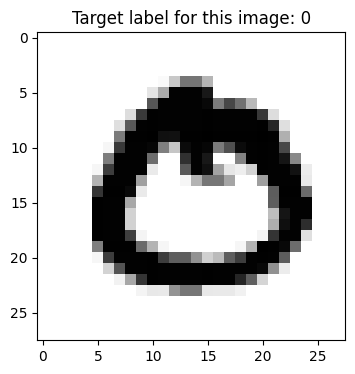

In [ ]:
image_label = 23

plt.figure(figsize=(4, 4))
plt.imshow(X[23].reshape(28, 28), cmap="binary")
plt.title(f'Target label for this image: {y[23]}')
plt.show()

#### Displaying more examples

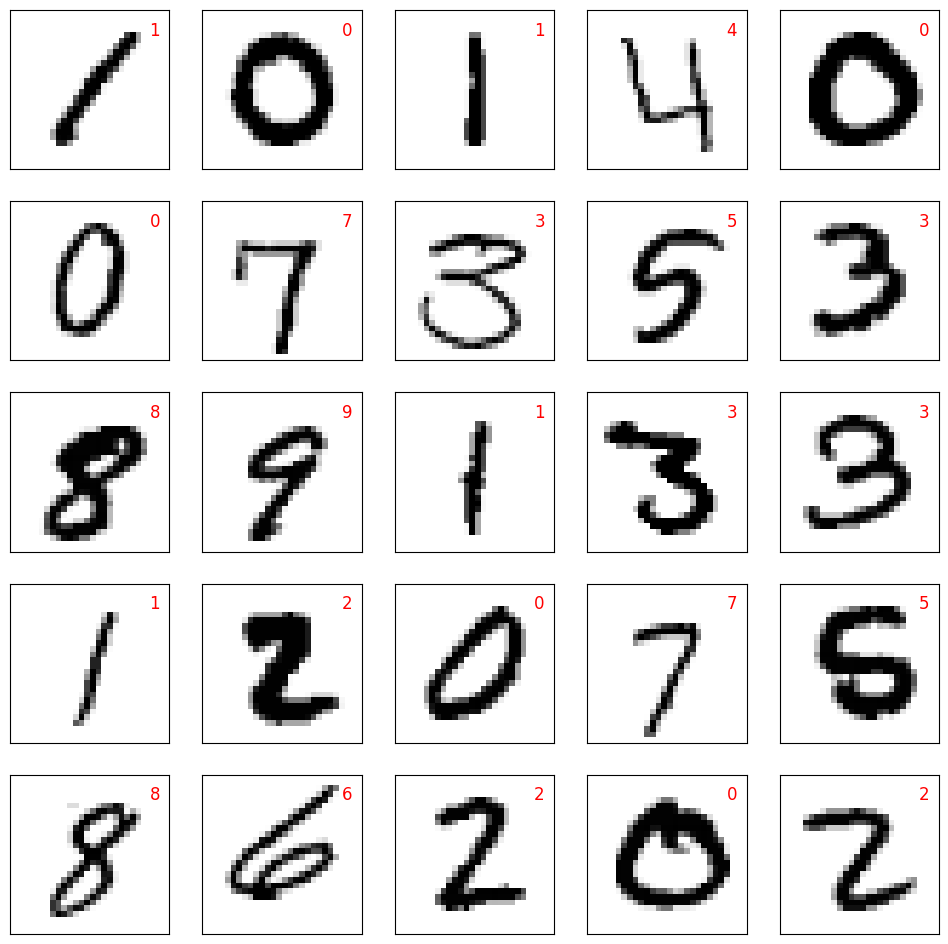

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(12, 12))
index = 0

for i in range(5):
    for j in range(5):

        axs[i, j].imshow(X[index].reshape(28, 28), cmap="binary")
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].text(x=24, y=4, s=str(y[index]), c='red', size=12)
        index += 1

#### Making data set and data generator

In [ ]:

# Separate into pixel data (X) and target labels (y)
X, y = data.iloc[:, 1:], data['label']
X = X.to_numpy()
y = y.to_numpy()

# Standardize pixel values to the range [0, 1]
X = X / 255

# Convert numpy arrays to torch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Reshape X to [N, C, H, W] format for input to neural network
X_tensor = X_tensor.reshape(X_tensor.shape[0], 1, 28, 28)

# Create PyTorch Dataset using TensorDataset(input_features, labels)
mnist_dataset = TensorDataset(X_tensor, y_tensor)

#### Spliting data into Training / Validation sets

In [ ]:
# Split dataset into training and validation sets
train_size = int(0.8 * len(mnist_dataset))
valid_size = len(mnist_dataset) - train_size
training_set, validation_set = random_split(mnist_dataset, [train_size, valid_size], generator=torch.Generator().manual_seed(1))

# Set batch size
batch_size = 64

In [ ]:
# Create DataLoader for training set
train_dl = DataLoader(training_set, batch_size=batch_size, shuffle=True)

# Create DataLoader for validation set
valid_dl = DataLoader(validation_set, batch_size=batch_size, shuffle=True)

#### Building the NN by using CNN

In [ ]:
# Define the updated model architecture
updated_model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Dropout(p=0.25),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Dropout(p=0.25),
    nn.Flatten(),
    nn.Linear(256 * 7 * 7, 512),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(512, 10)
)

In [ ]:
# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(updated_model.parameters(), lr=0.001)

# Set random seed
torch.manual_seed(1)

#### Training Function

In [ ]:
# Function to train the model and return the history
def train(model, num_epochs, train_dl, valid_dl):
    train_loss_history = []
    train_acc_history = []
    valid_loss_history = []
    valid_acc_history = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        for X_batch, y_batch in train_dl:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == y_batch).sum().item()
        train_loss /= len(train_dl.dataset)
        train_acc = train_correct / len(train_dl.dataset)
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        model.eval()
        valid_loss = 0.0
        valid_correct = 0
        with torch.no_grad():
            for X_val, y_val in valid_dl:
                outputs = model(X_val)
                loss = loss_fn(outputs, y_val)
                valid_loss += loss.item() * X_val.size(0)
                _, predicted = torch.max(outputs, 1)
                valid_correct += (predicted == y_val).sum().item()
        valid_loss /= len(valid_dl.dataset)
        valid_acc = valid_correct / len(valid_dl.dataset)
        valid_loss_history.append(valid_loss)
        valid_acc_history.append(valid_acc)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}')

    return train_loss_history, train_acc_history, valid_loss_history, valid_acc_history


#### Applying the train function

#### Visualizing training and validation loss plots

In [ ]:
# Train the updated model and get the history
train_loss_history, train_acc_history, valid_loss_history, valid_acc_history = train(updated_model, num_epochs=2, train_dl=train_dl, valid_dl=valid_dl)



Epoch 1/2, Train Loss: 0.1002, Train Acc: 0.9707, Valid Loss: 0.0456, Valid Acc: 0.9862
Epoch 2/2, Train Loss: 0.0596, Train Acc: 0.9813, Valid Loss: 0.0379, Valid Acc: 0.9882


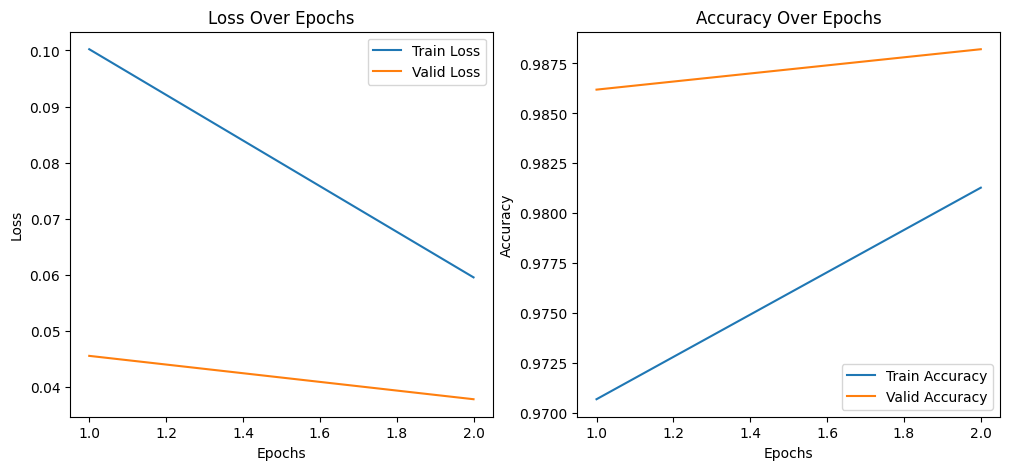

In [ ]:
# Plotting
epochs = range(1, 3)  # Number of epochs used for training

plt.figure(figsize=(12, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, label='Train Loss')
plt.plot(epochs, valid_loss_history, label='Valid Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_history, label='Train Accuracy')
plt.plot(epochs, valid_acc_history, label='Valid Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


#### Final test predictions

In [ ]:
# Read in the unlabeled test images and standardize
X_test = pd.read_csv('/content/test.csv')
X_test = X_test.to_numpy()
X_test = X_test / 255

# Convert test data to PyTorch tensor and reshape
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
X_test_tensor = X_test_tensor.reshape(X_test_tensor.shape[0], 28, 28)
X_test_tensor = torch.unsqueeze(X_test_tensor, 1)

In [ ]:
# Our neural network outputs logits for each class.
# Use torch.argmax to get the predicted class for each test image.

test_predicted_logits = updated_model(X_test_tensor)
test_predicted_classes = torch.argmax(test_predicted_logits, dim=1)

In [ ]:
# Convert predictions to a numpy array and create an array of image_ids for submission file:

test_predicted_classes = test_predicted_classes.numpy()
image_ids = np.arange(1, len(test_predicted_classes) + 1)

In [ ]:
test_predicted_classes

In [ ]:
# Create the final submission.csv file:

df = pd.DataFrame({"ImageId": image_ids, "Label": test_predicted_classes})
df.to_csv("/content/saved.csv", index=False)